In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import os 
import h5py
import sys
%matplotlib inline 

In [2]:
model_name = "Gaussian_scaling_phi.h5py"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi','j7_phi','j7_phi', 'j8_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi']
# output_keys = ['th_eta','th_phi', 'tl_eta', 'tl_phi']

output_length = len(output_keys)
input_length = len(input_keys)

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
def phi_transform(arr):
    mean = np.mean(arr)
    arr = arr-mean
    max0 = np.max(arr)
    arr = arr/max0/2.2
    x, y = arr[0:len(arr)//2], arr[len(arr)//2:]
    s = x**2 + y**2 
    z1 = x/np.sqrt(s)*np.sqrt(-2*np.log(s))
    z2 = y/np.sqrt(s)*np.sqrt(-2*np.log(s))
    z = np.append(z1, z2)
    max1 = np.max(np.abs(z))
    z = z/max1
    
    return (z, max0, max1, mean)

def invphi_transform(z, max0, max1, mean):
    z0 = z*max1
    z1, z2 = z0[0:len(z)//2], z0[len(z)//2:]
    s1 = np.exp(-1*(z1**2+z2**2)/2)
    x1 = z1*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    y1 = z2*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    arr = np.append(x1, y1)
    arr = arr*max0*2.2+mean
    
    return arr 

def meanmax_transform(arr):
    mean = np.mean(arr)
    arr = arr-mean
    max0 = np.max(np.abs(arr))
    z = arr/max0
    return (z, max0, 0, mean)

def invmeanmax_transform(z, max0, max1, mean):
    return z*max0+mean
    
def scale_arrays(keys):
    arrays = []
    maxi0 = []
    maxi1 = []
    mean = []
    for x in keys:
        var = np.array(dataset.get(x))[0:crop0]
        if x in phi_keys:
            arr, max0, max1, mu = phi_transform(var)
        else:
            arr, max0, max1, mu = meanmax_transform(var)
        arrays.append(arr)
        maxi0.append(max0)
        maxi1.append(max1)
        mean.append(mu)
    arrays = np.stack(arrays, axis=1)
    return (arrays, maxi0, maxi1, mean)

def invscale_arrays(keys, maxi0, maxi1, mean, arrays):
    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        max0 = maxi0[i]
        max1 = maxi1[i]
        mu = mean[i]
        if keys[i] in phi_keys:
            total.append(invphi_transform(z, max0, max1, mu))
        else:
            total.append(invmeanmax_transform(z, max0, max1, mu))
    return np.stack(total,1) 

In [7]:
# Convert into numpy arrays and mean normalize
crop0 =  100000 # Must be even

total_input, in_max0, in_max1, in_mean = scale_arrays(input_keys)

total_output, out_max0, out_max1, out_mean = scale_arrays(output_keys)

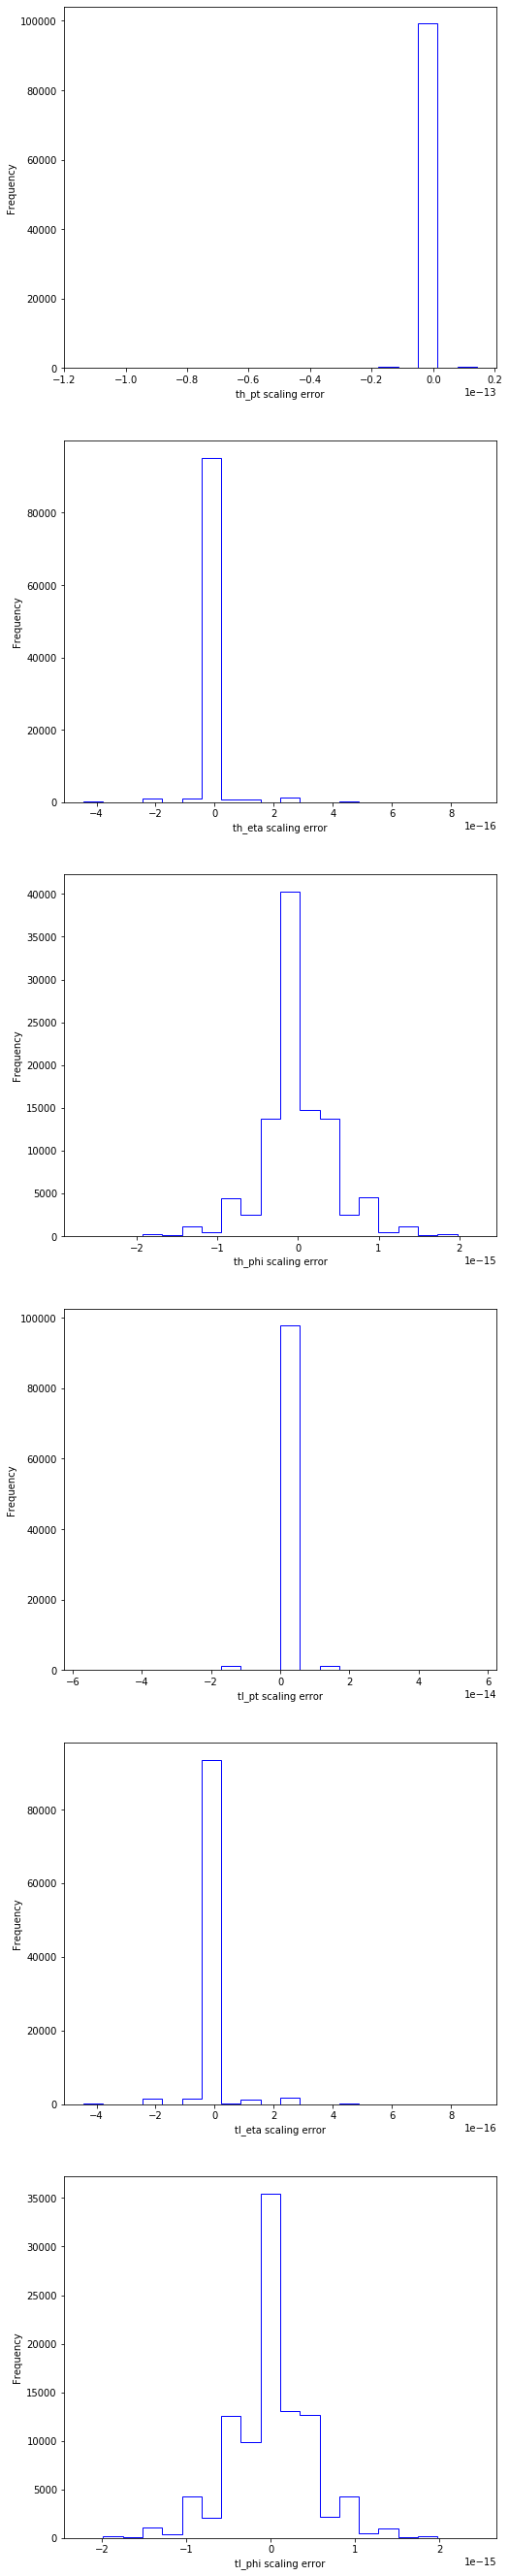

In [8]:
# Test inverse scaling

out_scaled = invscale_arrays(output_keys, out_max0, out_max1, out_mean, total_output)

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 45) (80000, 6)
(20000, 45) (20000, 6)


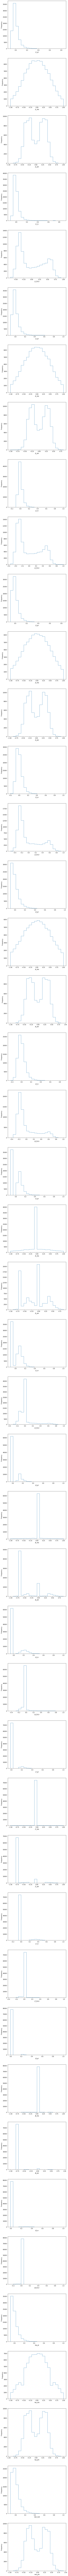

In [11]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [12]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23552     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 270,854
Trainable params: 270,854
Non-trainable params: 0
__________________________________________________

In [14]:
# Fit model

Epochs= 1024

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1524 - mse: 0.0554 - val_loss: 0.1481 - val_mse: 0.0519
Epoch 2/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1450 - mse: 0.0497 - val_loss: 0.1403 - val_mse: 0.0458
Epoch 3/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1366 - mse: 0.0429 - val_loss: 0.1321 - val_mse: 0.0392
Epoch 4/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1296 - mse: 0.0374 - val_loss: 0.1268 - val_mse: 0.0354
Epoch 5/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1256 - mse: 0.0350 - val_loss: 0.1239 - val_mse: 0.0341
Epoch 6/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1229 - mse: 0.0340 - val_loss: 0.1215 - val_mse: 0.0333
Epoch 7/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.1206 - mse: 0.0332 - val_loss: 0.1193 - val_mse: 0.0327
Epoch 8/1024
125/125 [==============================] - 1s 5ms

Epoch 62/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0645 - mse: 0.0275 - val_loss: 0.0646 - val_mse: 0.0279
Epoch 63/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0640 - mse: 0.0275 - val_loss: 0.0641 - val_mse: 0.0278
Epoch 64/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0635 - mse: 0.0274 - val_loss: 0.0637 - val_mse: 0.0278
Epoch 65/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0630 - mse: 0.0274 - val_loss: 0.0632 - val_mse: 0.0278
Epoch 66/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0626 - mse: 0.0274 - val_loss: 0.0628 - val_mse: 0.0278
Epoch 67/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0621 - mse: 0.0274 - val_loss: 0.0623 - val_mse: 0.0278
Epoch 68/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0617 - mse: 0.0273 - val_loss: 0.0619 - val_mse: 0.0277
Epoch 69/1024
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.0474 - mse: 0.0261 - val_loss: 0.0481 - val_mse: 0.0269
Epoch 123/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0473 - mse: 0.0261 - val_loss: 0.0480 - val_mse: 0.0269
Epoch 124/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0471 - mse: 0.0261 - val_loss: 0.0479 - val_mse: 0.0269
Epoch 125/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0470 - mse: 0.0261 - val_loss: 0.0477 - val_mse: 0.0269
Epoch 126/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0468 - mse: 0.0260 - val_loss: 0.0476 - val_mse: 0.0269
Epoch 127/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0467 - mse: 0.0260 - val_loss: 0.0474 - val_mse: 0.0269
Epoch 128/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0465 - mse: 0.0260 - val_loss: 0.0473 - val_mse: 0.0268
Epoch 129/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0410 - mse: 0.0252 - val_loss: 0.0422 - val_mse: 0.0265
Epoch 183/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0409 - mse: 0.0252 - val_loss: 0.0421 - val_mse: 0.0265
Epoch 184/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0408 - mse: 0.0252 - val_loss: 0.0421 - val_mse: 0.0265
Epoch 185/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0407 - mse: 0.0252 - val_loss: 0.0420 - val_mse: 0.0265
Epoch 186/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0407 - mse: 0.0252 - val_loss: 0.0419 - val_mse: 0.0265
Epoch 187/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0406 - mse: 0.0252 - val_loss: 0.0419 - val_mse: 0.0265
Epoch 188/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0405 - mse: 0.0252 - val_loss: 0.0418 - val_mse: 0.0265
Epoch 189/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0374 - mse: 0.0246 - val_loss: 0.0392 - val_mse: 0.0264
Epoch 243/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0373 - mse: 0.0246 - val_loss: 0.0391 - val_mse: 0.0264
Epoch 244/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0373 - mse: 0.0246 - val_loss: 0.0391 - val_mse: 0.0264
Epoch 245/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0373 - mse: 0.0245 - val_loss: 0.0390 - val_mse: 0.0264
Epoch 246/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0245 - val_loss: 0.0390 - val_mse: 0.0264
Epoch 247/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0245 - val_loss: 0.0390 - val_mse: 0.0264
Epoch 248/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0371 - mse: 0.0245 - val_loss: 0.0389 - val_mse: 0.0264
Epoch 249/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0240 - val_loss: 0.0374 - val_mse: 0.0263
Epoch 303/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0350 - mse: 0.0240 - val_loss: 0.0374 - val_mse: 0.0263
Epoch 304/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0350 - mse: 0.0240 - val_loss: 0.0373 - val_mse: 0.0263
Epoch 305/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0350 - mse: 0.0240 - val_loss: 0.0373 - val_mse: 0.0263
Epoch 306/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0240 - val_loss: 0.0373 - val_mse: 0.0263
Epoch 307/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0240 - val_loss: 0.0373 - val_mse: 0.0263
Epoch 308/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0349 - mse: 0.0240 - val_loss: 0.0372 - val_mse: 0.0263
Epoch 309/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0334 - mse: 0.0235 - val_loss: 0.0363 - val_mse: 0.0264
Epoch 363/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0334 - mse: 0.0235 - val_loss: 0.0363 - val_mse: 0.0264
Epoch 364/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0334 - mse: 0.0234 - val_loss: 0.0363 - val_mse: 0.0264
Epoch 365/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0234 - val_loss: 0.0363 - val_mse: 0.0264
Epoch 366/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0234 - val_loss: 0.0363 - val_mse: 0.0264
Epoch 367/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0234 - val_loss: 0.0362 - val_mse: 0.0264
Epoch 368/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0234 - val_loss: 0.0362 - val_mse: 0.0264
Epoch 369/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0229 - val_loss: 0.0357 - val_mse: 0.0265
Epoch 423/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0229 - val_loss: 0.0357 - val_mse: 0.0265
Epoch 424/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0229 - val_loss: 0.0356 - val_mse: 0.0265
Epoch 425/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0229 - val_loss: 0.0356 - val_mse: 0.0265
Epoch 426/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0229 - val_loss: 0.0356 - val_mse: 0.0265
Epoch 427/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0229 - val_loss: 0.0356 - val_mse: 0.0265
Epoch 428/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0229 - val_loss: 0.0356 - val_mse: 0.0265
Epoch 429/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0224 - val_loss: 0.0353 - val_mse: 0.0266
Epoch 483/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0224 - val_loss: 0.0353 - val_mse: 0.0266
Epoch 484/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0224 - val_loss: 0.0353 - val_mse: 0.0266
Epoch 485/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0224 - val_loss: 0.0353 - val_mse: 0.0266
Epoch 486/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0224 - val_loss: 0.0353 - val_mse: 0.0266
Epoch 487/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0224 - val_loss: 0.0353 - val_mse: 0.0266
Epoch 488/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0224 - val_loss: 0.0353 - val_mse: 0.0266
Epoch 489/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0219 - val_loss: 0.0351 - val_mse: 0.0268
Epoch 543/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0219 - val_loss: 0.0351 - val_mse: 0.0268
Epoch 544/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0219 - val_loss: 0.0351 - val_mse: 0.0268
Epoch 545/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0219 - val_loss: 0.0351 - val_mse: 0.0268
Epoch 546/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0219 - val_loss: 0.0351 - val_mse: 0.0268
Epoch 547/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0219 - val_loss: 0.0351 - val_mse: 0.0268
Epoch 548/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0219 - val_loss: 0.0351 - val_mse: 0.0268
Epoch 549/1024
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0295 - mse: 0.0214 - val_loss: 0.0351 - val_mse: 0.0270
Epoch 603/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0295 - mse: 0.0214 - val_loss: 0.0351 - val_mse: 0.0270
Epoch 604/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0295 - mse: 0.0214 - val_loss: 0.0351 - val_mse: 0.0270
Epoch 605/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0295 - mse: 0.0214 - val_loss: 0.0351 - val_mse: 0.0270
Epoch 606/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0295 - mse: 0.0214 - val_loss: 0.0351 - val_mse: 0.0270
Epoch 607/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0295 - mse: 0.0214 - val_loss: 0.0351 - val_mse: 0.0270
Epoch 608/1024
125/125 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0214 - val_loss: 0.0351 - val_mse: 0.0270
Epoch 609/1024
125/125 [==============================] - 1s 5m

In [15]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Gaussian_scaling_phi.h5py/assets


Text(0.5, 1.0, 'MSE loss')

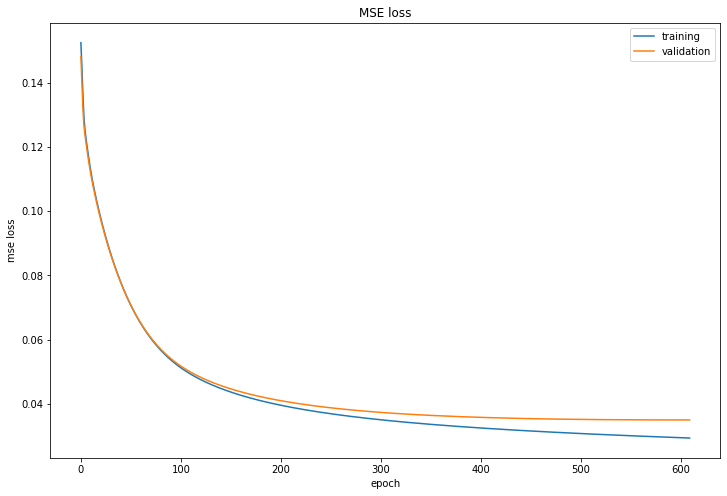

In [16]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [17]:
predictions = model.predict(test_input)

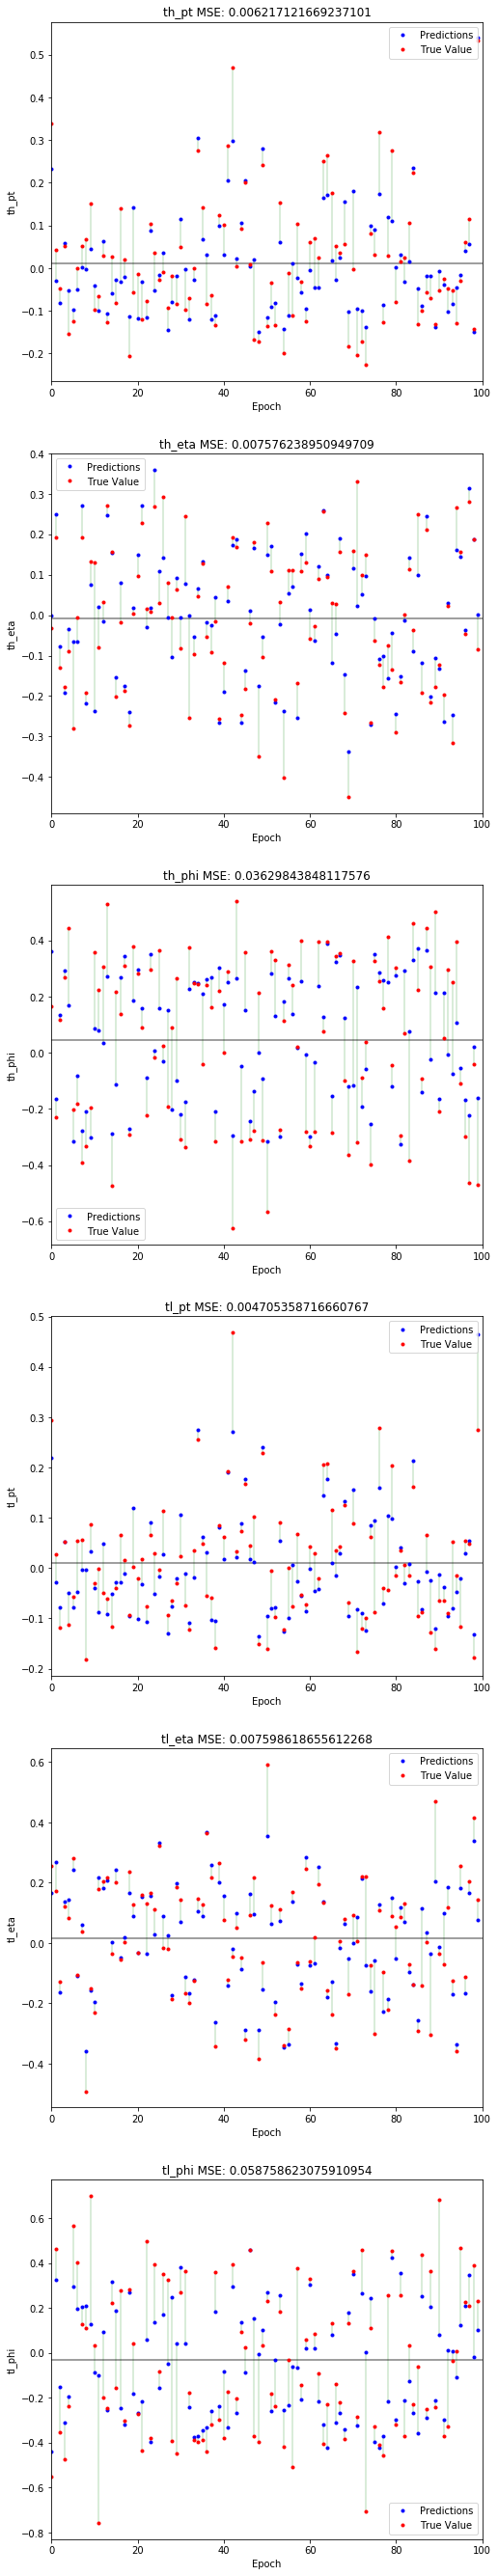

In [18]:
# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [19]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.02671463768995645
th_pt MSE :  0.0068424939
th_eta MSE :  0.0115991163
th_phi MSE :  0.0650347295
tl_pt MSE :  0.0049807676
tl_eta MSE :  0.0096745271
tl_phi MSE :  0.0621561917


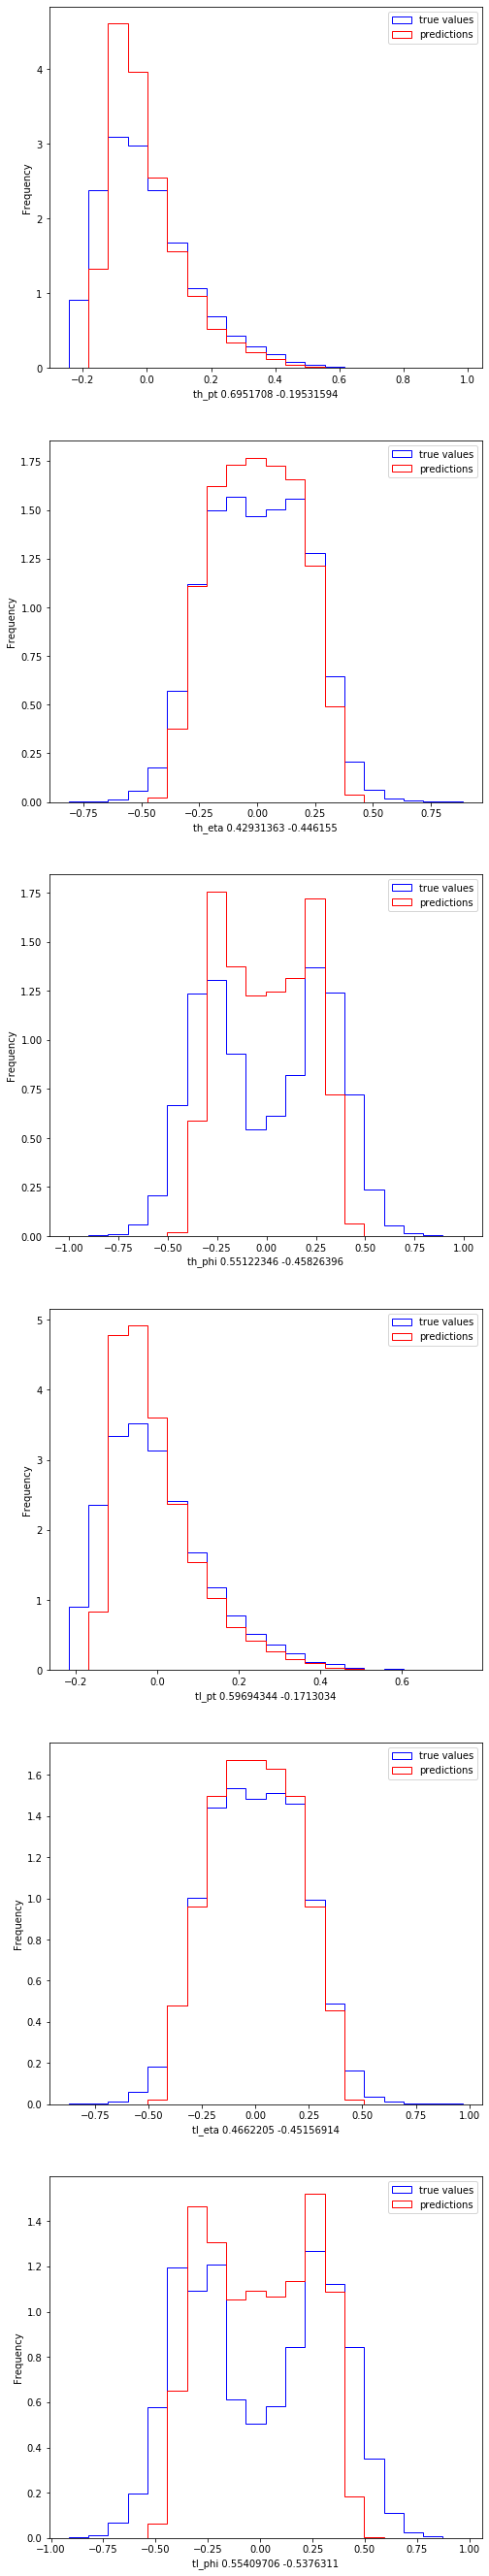

In [24]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [21]:
print(output_keys, out_max0, out_max1)

['th_pt', 'th_eta', 'th_phi', 'tl_pt', 'tl_eta', 'tl_phi'] [534.9200431001957, 7.416863749875853, 3.1451409426508654, 601.9327875497579, 7.073975641815083, 3.1426326432101814] [0, 0, 4.8827519145532525, 0, 0, 4.5632160771265005]


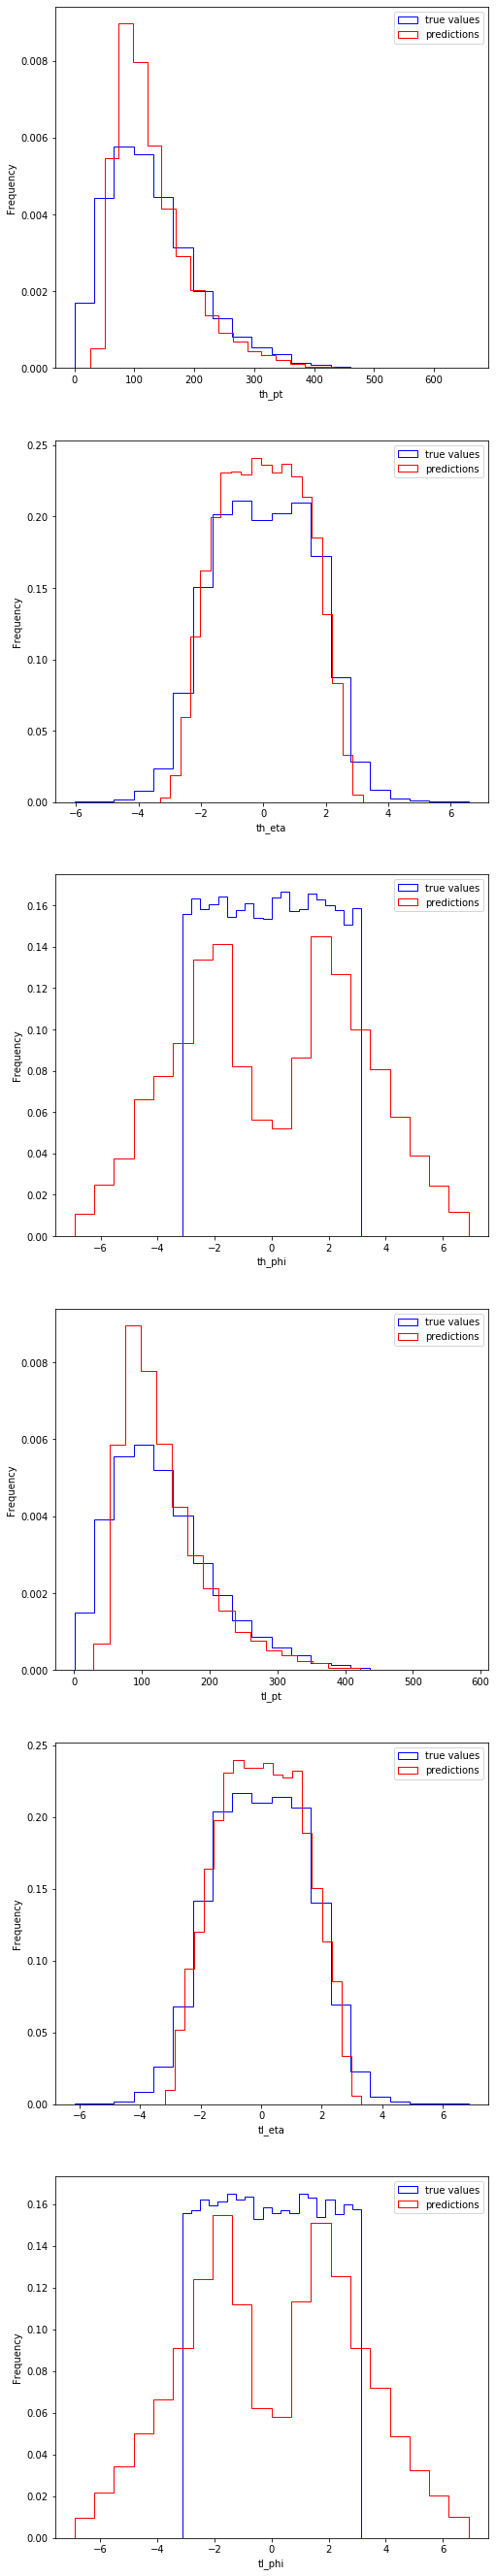

In [22]:
# Histograms to the original scale 

total_predictions = model.predict(total_input) 
out_scaled = invscale_arrays(output_keys, out_max0, out_max1, out_mean, total_output)[split:,:]

predict_scaled = invscale_arrays(output_keys, out_max0, out_max1, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [23]:
for i in range(output_length):
    MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] -out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1957.9074517145
Original Scale th_eta MSE :  0.6380658525
Original Scale th_phi MSE :  7.9096722261
Original Scale tl_pt MSE :  1804.6470688604
Original Scale tl_eta MSE :  0.4841242842
Original Scale tl_phi MSE :  6.6330714455


In [ ]:
def invphi_transform(z, max0, max1, mean):
    z0 = z*max1
    z1, z2 = z0[0:len(z)//2], z0[len(z)//2:]
    s1 = np.exp(-1*(z1**2+z2**2)/2)
    x1 = z1*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    y1 = z2*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
    arr = np.append(x1, y1)
    arr = arr*max0*2.2+mean
    
    return arr 

(array([ 524., 2291., 3797., 4413., 4597., 4642., 4286., 3837., 3395.,
        3037., 2604., 2140., 1921., 1584., 1437., 1294., 1202., 1044.,
        1031.,  924.]),
 array([0.01382319, 0.06312638, 0.11242956, 0.16173275, 0.21103594,
        0.2603391 , 0.30964231, 0.3589455 , 0.4082487 , 0.45755187,
        0.5068551 , 0.55615824, 0.6054614 , 0.6547646 , 0.7040678 ,
        0.753371  , 0.8026742 , 0.85197735, 0.9012806 , 0.95058376,
        0.99988693], dtype=float32),
 <a list of 1 Patch objects>)

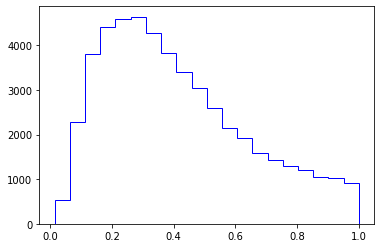

In [45]:
z = total_predictions[:,2]
max0 = out_max0[2]
max1 = out_max1[2]
mean = out_mean[2]
z0 = z*max1

z1, z2 = z0[0:len(z)//2], z0[len(z)//2:]
s1 = np.exp(-1*(z1**2+z2**2)/2)
x1 = z1*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
y1 = z2*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
arr = np.append(x1, y1)
ar1r = arr*max0*2.2+mean
plt.hist(s1,20,histtype='step', color='b')

[534.9200431001957, 7.416863749875853, 3.1451409426508654, 601.9327875497579, 7.073975641815083, 3.1426326432101814] [0, 0, 4.8827519145532525, 0, 0, 4.5632160771265005]


(array([3876., 3833., 3873., 3972., 3943., 3994., 3879., 3910., 3878.,
        3836., 2963., 2199., 1652., 1242.,  975.,  761.,  563.,  358.,
         211.,   82.]),
 array([4.97260283e-07, 2.05334406e-02, 4.10663840e-02, 6.15993273e-02,
        8.21322707e-02, 1.02665214e-01, 1.23198157e-01, 1.43731101e-01,
        1.64264044e-01, 1.84796987e-01, 2.05329931e-01, 2.25862874e-01,
        2.46395818e-01, 2.66928761e-01, 2.87461704e-01, 3.07994648e-01,
        3.28527591e-01, 3.49060534e-01, 3.69593478e-01, 3.90126421e-01,
        4.10659364e-01]),
 <a list of 1 Patch objects>)

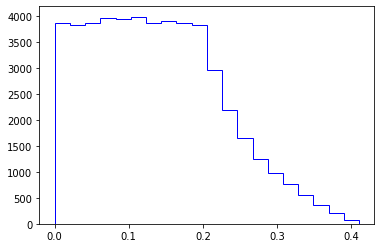

In [46]:
z = total_output[:,2]
max0 = out_max0[2]
max1 = out_max1[2]
mean = out_mean[2]

print(out_max0, out_max1)
z0 = z*max1

z1, z2 = z0[0:len(z)//2], z0[len(z)//2:]
s1 = np.exp(-1*(z1**2+z2**2)/2)
x1 = z1*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
y1 = z2*np.sqrt(s1)/np.sqrt(-2*np.log(s1))
arr = np.append(x1, y1)
arr1 = arr*max0*2.2+mean
plt.hist(s1,20,histtype='step', color='b')